#Solutions for Non-Stationary Time Series

In [0]:
import numpy as np 
import scipy.fftpack 
import matplotlib.pyplot as plt

Creating a Signal (Chirp)

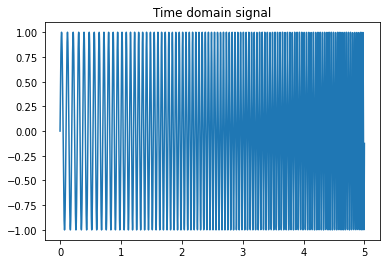

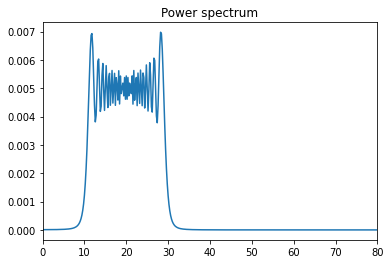

In [2]:
fs     = 1000 # sampling rate
time   = np.arange(0,5,1/fs) #5 seconds long
npnts  = len(time)
f      = [10,30] # frequencies 
ff     = np.linspace(f[0],np.mean(f),npnts) #creates sequences of evenly spaced numbers structured as a NumPy array
signal = np.sin(2*np.pi*ff*time)
#The Chip goes from 10Hz to 30Hz in a course of 5 sec


plt.plot(time,signal)
plt.title('Time domain signal')
plt.show()

# compute power spectrum
sigpow = 2*np.abs(scipy.fftpack.fft(signal)/npnts)**2
hz     = np.linspace(0,fs/2,int(np.floor(npnts/2)+1))

plt.plot(hz,sigpow[0:len(hz)])
plt.xlim([0,80])
plt.title('Power spectrum')
plt.show()

Just by Looking at the Power Spectrum, you cannot guess what the Time domain Signal would look like.

#Short-Time FFT 
The first method of Time-frequency Analysis

![](https://drive.google.com/uc?id=1iHWpYnhYPkcPMxRPgjjk4pwAxDrrLAh5)

Refernence: Cohen, Analysis Neural Time Series Data, MIT Press, 2014

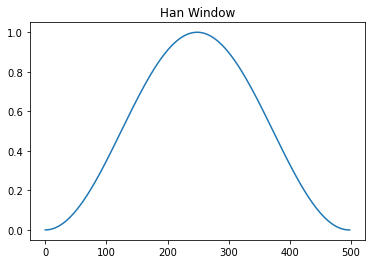

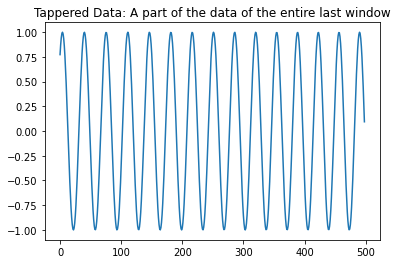

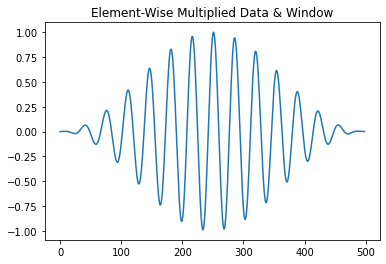

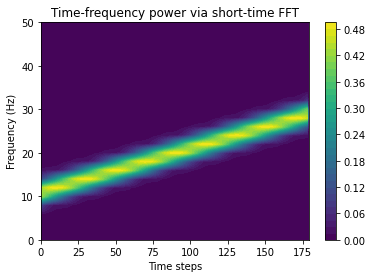

In [12]:
## short-time FFT

winlen   = 500  # window length
stepsize =  25  # step size for STFFT
numsteps = np.floor( (npnts-winlen)/stepsize )

hz = np.linspace(0,fs/2,int(np.floor(winlen/2)+1))


# initialize time-frequency matrix
tf = np.zeros( (len(hz),int(numsteps)) )

# Hann taper  [Windowing the Data]
hwin = .5*(1-np.cos(2*np.pi*np.linspace(0,winlen,winlen-1) / (winlen-1)))
plt.plot(hwin)
plt.title('Han Window')
plt.show()

# loop over time windows
for ti in range(0,int(numsteps)-1):
    
    # extract part of the signal
    tidx    = range(ti*stepsize+1,ti*stepsize+winlen)
    tapdata = signal[tidx]
    
    # FFT of these data
    x = scipy.fftpack.fft( np.multiply(hwin,tapdata) ) /winlen
    
    # and put in matrix
    tf[:,ti] = 2*np.abs(x[0:len(hz)])


plt.plot(tapdata)
plt.title('Tappered Data: A part of the data of the entire last window') 
#this is to show that we wanted the data as stationary as possible; & this is kindof achieved 
plt.show()

plt.plot(np.multiply(tapdata,hwin))#Element Wise Multiplied the hwin with tappered data (just to understand)
plt.title("Element-Wise Multiplied Data & Window")
plt.show()
#since the output starts & ends at zero, this ensures we won't have any sharp edges in the frequecny domain 

plt.contourf(range(0,int(numsteps)),hz,tf,40)#,'linecolor','none')
plt.ylim([0,50])
plt.clim([0,.5])
plt.xlabel('Time steps')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power via short-time FFT')
plt.colorbar()
plt.show()

The Time-frequency power via short-time FFT shows the variation of frequency over time. It starts with 10Hz & goes on upto 30Hz.

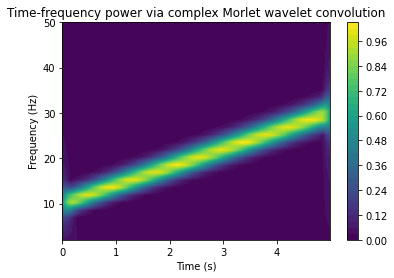

In [14]:
## Morlet wavelet convolution

# frequencies used in analysis
nfrex = 30 
frex  = np.linspace(2,50,nfrex)  #30 frequencies between 2 & 50
wtime = np.arange(-2,2,1/fs)
gausS = np.linspace(5,35,nfrex)

# convolution parameters
nConv = len(wtime) + npnts - 1
halfw = np.floor(len(wtime)/2)

# initialize time-frequency output matrix
tf = np.zeros((nfrex,npnts))

# FFT of signal
signalX = scipy.fftpack.fft(signal,nConv)

# loop over wavelet frequencies
for fi in range(0,nfrex):
    
    # create the wavelet
    s   = ( gausS[fi]/(2*np.pi*frex[fi]) )**2
    cmw = np.multiply( np.exp(1j*2*np.pi*frex[fi]*wtime) , np.exp( (-wtime**2)/s ) )
    #Sine * Gaussian
    
    # compute its Fourier spectrum and normalize
    cmwX = scipy.fftpack.fft(cmw,nConv)
    cmwX = cmwX/max(cmwX); # scale to 1
  
    # convolution result is inverse FFT of pointwise multiplication of spectra
    convres  = scipy.fftpack.ifft( np.multiply( signalX,cmwX ) )
    tf[fi,:] = 2*np.abs(convres[range(int(halfw+1),int(len(convres)-halfw+2))])

plt.contourf(time,frex,tf,40)
#set(gca,'ylim',[0 50],'xlim',[0 5],'clim',[0 1])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power via complex Morlet wavelet convolution')
plt.colorbar()
plt.show()

We got the same Result.